In [ ]:
import numpy as np

from scipy.integrate import quad_vec
from scipy.integrate import solve_ivp
from scipy.linalg import expm
import scipy.optimize as opt
from scipy.sparse import bmat

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import time as tm
import ray

k1= 0.1;k2= 0.2
A = np.array([[0,0,1,0],[0,0,0,1],[0,0,-k1,0],[0,0,0,-k2]])
B = np.array([[0,0],[0,0],[k1,0],[0,k2]])
R = np.array([[0.1,0],[0,0.1]])

BRB = B@np.linalg.inv(R)@B.T

In [ ]:
def overlap(a, b): # 2d implementation
    '''
    returns rectangle overlap between two rectangles
    inputs: a, b, rectangles [[xmin, ymin], [xmax, ymax]] (2d)
    returns: overlapped rectangle, or a, b if no overlap
    '''

    ab1x = max(a[0,0], b[0,0])
    ab1y = max(a[0,1], b[0,1])

    dx = min(a[1,0], b[1,0]) - ab1x
    dy = min(a[1,1], b[1,1]) - ab1y
    if (dx>=0) and (dy>=0):
        return np.array([[[ab1x, ab1y], [ab1x+dx, ab1y+dy]]])
    else:
        # return np.array([a, b])
        return None

def non_det_filter(xbar_prev, xhat_now):
    '''
    implements non-deterministic filter
    inputs: xbar_prev, xhat_now
    xbar_prev: previous estimate of occ_space
    xhat_now: current estimate of occ_space
    
    output: xbar_now, updated estimate of occ_space
    '''
    if len(xbar_prev) == 0:
        return xhat_now
    else:
        ab_all = []
        for a in xbar_prev:
            for b in xhat_now:
                # print(ab)
                ab = overlap(a, b)
                if (np.any(np.all(a == ab))) or (np.any(np.all(b == ab))) or (ab is None):
                    continue
                else:
                    ab_all.append(ab)
        if len(ab_all) == 0:
            return []
        else:
            xbar_now = np.concatenate(ab_all)
            return xbar_now

In [ ]:
# cost >= time
def forward_box(state, r, vx_range, vy_range):
    vxmax = max(vx_range)
    vymax = max(vy_range)
    xmax,ymax = state[0:2] + r*np.array([vxmax,vymax])
    xmin,ymin = state[0:2]# + np.array([(state[2]/k1)*(1-np.exp(-k1*r)),(state[3]/k2)*(1-np.exp(-k2*r))]) # brake
    return xmax,ymax,xmin,ymin

def backward_box(state, r, vx_range, vy_range):
    vxmin = min(vx_range)
    vymin = min(vy_range)
    vxmax = max(vx_range)
    vymax = max(vy_range)
    xmax,ymax = state[0:2] - r*np.array([vxmin,vymin])
    xmin,ymin = state[0:2] - r*np.array([vxmax,vymax]) # - np.array([state[2]/k1,state[3]/k2]) # brake
    return xmax,ymax,xmin,ymin

In [ ]:
def gramian(t):
    # start = tm.time()
    # def integrand(s):
    #     return expm(A*s)@BRB@expm(A.T*s)
    
    # end = tm.time()
    # print(end-start)
    # return quad_vec(integrand, 0, t)[0]
    def gdot(t,g0):
        g = g0.reshape(4,4)
        res = A@g + g@A.T + BRB
        return res.reshape(-1)
    return solve_ivp(gdot,[0,t],np.zeros(16)).y[:,-1].reshape(4,4)


'''
def cost_optimal(state0, state1):
    def cdot(t):
        x = state1-expm(A*t)@state0
        G = gramian(t)
        if np.linalg.det(G) == 0:
            # G = G + np.eye(4)
            print(G)
        d = np.linalg.inv(G)@x
        return 1 - 2*np.transpose(A@state1)@d-d.T@BRB@d
    def cddot(t):
        x = state1-expm(A*t)@state0
        G = gramian(t)
        Gprime = expm(A*t)@BRB@expm(A.T*t)
        Ginvdot = -np.linalg.inv(G)@Gprime@np.linalg.inv(G)
        d = np.linalg.inv(G)@x
        ddot = Ginvdot@x + np.linalg.inv(G)@(-A@x)
        return -2*(A@state1).T@ddot - d.T@BRB@ddot - ddot.T@BRB@d
    try:
        t_star = opt.newton(cdot, 0.5, fprime = cddot, tol = 1e-6, maxiter=10)
    except:
        t_star = 100 # arbitrary large number
    # t_star = opt.brentq(cdot,1e-6,10)
    def cost(t):
        x = state1-expm(A*t)@state0
        G = gramian(t)
        return t + x.T@np.linalg.inv(G)@x
    return cost(t_star), t_star
'''

def cost_optimal(state0, state1, r):
    def cost(t):
        x = state1-expm(A*t)@state0
        G = gramian(t)
        if np.linalg.det(G) == 0:
            # G = G + np.eye(4)
            print(G)
        c =t+x.T@np.linalg.inv(G)@x
        return c
    t_star = opt.minimize(cost, r/2, bounds = [(0,r)], method = 'trust-constr', options={'gtol': 1e-3, 'maxiter': 10}).x[0]
    return cost(t_star), t_star
'''
def cost_optimal(state0, state1, dt):
    def cost(t):
        x = state1-expm(A*t)@state0
        G = gramian(t)
        if np.linalg.det(G) == 0:
            # G = G + np.eye(4)
            print(G)
        c = t+x.T@np.linalg.inv(G)@x
        return c
    for t in np.arange(dt,5,dt):
        start = tm.time()
        if cost(t) < cost(t+dt):
            t_star = t
            break
        end = tm.time()
        if end-start > 0.01:
            print(gramian(t))
    return cost(t_star), t_star
'''

In [ ]:
def filter_reachable(state: np.ndarray, state_set: list, r, vx_range, vy_range, direction: str):
    """
    Filter reachable states

    Args:
        state (np.ndarray): Current state
        state_set (np.ndarray): Set of states to filter
        dt (float): Time step

    Returns:
        np.ndarray: Filtered set of states
    """
    if direction == 'F':
        box = forward_box
    elif direction == 'B':
        box = backward_box
    
    xmax, ymax, xmin, ymin= box(state,r,vx_range,vy_range)
    # print(xmax,ymax,xmin,ymin)
    state_set_filtered = []
    cost_set_filtered = []
    time_set_filtered = []
    for idx in range(len(state_set)):
        state_i = state_set[idx]
        if np.any(state_i != state):
            if xmin <= state_i[0] <= xmax and ymin <= state_i[1] <= ymax:
                # start = tm.time()
                if direction == 'F':
                    cost, time = cost_optimal(state, state_i, r)
                elif direction == 'B':
                    cost, time = cost_optimal(state_i, state, r)
                # end = tm.time()
                # print(end-start)
                # print(cost, time)
                if cost <= r:
                    state_set_filtered.append(idx)
                    cost_set_filtered.append(cost)
                    time_set_filtered.append(time)
    return state_set_filtered, cost_set_filtered, time_set_filtered

In [ ]:
def gen_trajectory(s0, s1, Ginv, tau, dt):
    
    # integrating directly
    # in RRT* paper, they use Runge-Kutta to solve ODE
    # G = np.zeros((4,4))
    # for t_prime in np.arange(0,tau,dt):
    #     G += dt*scipy.linalg.expm(A*t_prime)@B@B.T@scipy.linalg.expm(A.T*t_prime)
    # start = tm.time()
    sbar = expm(A*tau)@s0
    # def xbardot(t, xbar):
    #     return A@xbar
    # sbar = solve_ivp(xbardot,[0,tau],s0).y[:,-1]
    
    d = Ginv@(s1 - sbar)
    
    block_mat = bmat([[A,BRB.T],[None,-A.T]]).toarray()
    block_vec = np.hstack([s1,d])
    
    def xydot(t,xy):
        return block_mat@xy

    waypoints = solve_ivp(xydot,[tau,0],block_vec,t_eval = np.arange(tau, 0, -dt)).y
    x_waypoints = waypoints[0:4,:].T
    u_waypoints = (np.linalg.inv(R)@B.T@waypoints[4:,:]).T
    # waypoints = [expm(block_mat*(t_prime-tau))@(block_vec) for t_prime in np.arange(0,tau,dt)]
    # x_waypoints = [waypoint[0:4] for waypoint in waypoints]
    # u_waypoints = [np.linalg.inv(R)@B.T@waypoint[4:] for waypoint in waypoints]

    # end = tm.time()
    # print('time: ', end-start)
    return x_waypoints, u_waypoints

def show_trajectory(ax, s0, s1, Ginv, tau, dt, c_='gray', linewidth_=0.5):
    x_waypoints,_ = gen_trajectory(s0, s1, Ginv, tau, dt)
    M = np.zeros((4, int(np.abs(np.ceil(tau/dt)))))
    for i in range(len(x_waypoints)):
        M[:, i] = x_waypoints[i]
    # print(s0, s1, M[:,0], M[:,-1])
    ax.plot(M[0, :], M[1, :], c=c_, linewidth=linewidth_)

def gen_path(s0, s1, dx):
    dx, dy = s1[0] - s0[0], s1[1] - s0[1]
    yaw = np.arctan2(dy, dx)
    d = np.hypot(dx, dy)
    steps = np.arange(0, d, dx).reshape(-1, 1)
    pts = s0[0:2] + steps * np.array([np.cos(yaw), np.sin(yaw)])
    return np.vstack((pts, s1[0:2]))

In [ ]:
# test cell
Ginv = np.linalg.inv(gramian(2))
tau = 2
dt = 0.05
s0 = np.array([0.5,0.5,0,0])
s1 = np.array([0.4,0.6,0,0.1])
sbar = expm(A*tau)@s0
d = Ginv@(s1 - sbar)
    
block_mat = bmat([[A,BRB],[None,-A.T]]).toarray()
block_vec = np.hstack([s1,d])

In [ ]:
# test cell
gen_trajectory(s0, s1, Ginv, tau, dt)

In [ ]:
# https://bryceboe.com/2006/10/23/line-segment-intersection-algorithm/
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

# https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       return False

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return [x, y]

def find_frontier(xbar_now, world_box, start, FoV):
    # occ_space = 2D array
    # start = [x,y,psi]
    # FoV = total angle
    # returns frontier = list of np.array[[x1,y1],[x2,y2]]
    ray_left = start[2]+FoV/2
    ray_right = start[2]-FoV/2
    box_vertices = {}
    vertex_rays = {'left':ray_left,'right':ray_right}
    rays = []
    frontier = {}
    scaling = np.linalg.norm(world_box[0]-world_box[1])
    
    world_vertices = [world_box[0],np.array([world_box[1][0],world_box[0][1]]),world_box[1],np.array([world_box[0][0],world_box[1][1]])]
    world_edges = np.array([[world_vertices[i],world_vertices[(i+1)%4]] for i in range(4)])
    
    # create {box: 4 vertices}
    # find all rays corresponding to all vertices
    for i in range(len(xbar_now)):
        obstacle = xbar_now[i]
        vertices = [obstacle[0],np.array([obstacle[1][0],obstacle[0][1]]),obstacle[1],np.array([obstacle[0][0],obstacle[1][1]])]
        box_vertices[i] = vertices
        for j in range(len(vertices)):
            vertex = vertices[j]
            ray = np.mod(np.arctan2(vertex[1]-start[1],vertex[0]-start[0]),2*np.pi)
            if ray_right <= ray <= ray_left: # vertex is in FoV
                vertex_rays[vertex.tobytes()] = ray
    
    # discard rays in the way
    for vert, ray in vertex_rays.items():
        show = True
        if type(vert) == bytes:
            vertex = np.frombuffer(vert)
        else:
            vertex = np.array(start[0:2])
        ray_line = np.array([start[0:2],start[0:2]+scaling*np.array([np.cos(ray),np.sin(ray)])])
        
        segments = []
        for world_edge in world_edges:
            if intersect(world_edge[0],world_edge[1],ray_line[0],ray_line[1]):
                intersection = line_intersection(world_edge, ray_line)
                segment = np.array([vertex, intersection])
        segments.append(segment)

        # for this ray, look at each box
        for box, vertices in box_vertices.items():
            edges =np.array([[vertices[i],vertices[(i+1)%4]] for i in range(4)])
            if np.any(np.all(vertices == vertex, axis = 1)): # same box
                # make sure ray doesn't intersect with its own box
                for edge in edges:
                    if np.any(np.all(edge == vertex, axis = 1)): # this edge is for this vertex
                        continue
                    else:
                        # angle1 = np.mod(np.arctan((edge[0][1]-start[1])/(edge[0][0]-start[0])),np.pi)
                        # angle2 = np.mod(np.arctan((edge[1][1]-start[1])/(edge[1][0]-start[0])),np.pi)
                        # if angle1 <= ray <= angle2 or angle2 <= ray <= angle1:
                        if intersect(edge[0],edge[1],ray_line[0],ray_line[1]):
                            # print('same box', edge, ray, angle1, angle2)
                            show = False
            else: # different box
                # discard rays blocked by other boxes
                # get edges
                for edge in edges:
                    # find intersection
                    if intersect(edge[0],edge[1],ray_line[0],ray_line[1]):
                        intersection = line_intersection(edge, ray_line)
                        # compute distance
                        dist_to_edge = np.linalg.norm(np.array(intersection)-np.array(start[0:2]))
                        dist_to_vertex = np.linalg.norm(vertex-np.array(start[0:2]))
                        if dist_to_edge < dist_to_vertex:
                            # print('different box', edge, ray, intersection, dist_to_edge, dist_to_vertex)
                            show = False
                        else:
                            segments.append(np.array([vertex, intersection]))
                        
        if ray not in rays and show == True:
            rays.append(ray)
            segments_len = np.array([np.linalg.norm(segment[0]-segment[1]) for segment in segments])
            frontier[ray] = segments[np.argmin(segments_len)]

    
    
    return frontier

def find_candidates(frontier, radius):
    candidates = []
    for ray_angle, segment in frontier.items():
        # segment: [[x1,y1],[x2,y2]]
        segment_len = np.linalg.norm(segment[0]-segment[1])
        num_segments = int(np.floor(0.5*segment_len/radius))
        for i in range(num_segments):
            candidates.append(segment[0] + np.array([2*(i+1/2)*radius*np.cos(ray_angle),2*(i+1/2)*radius*np.sin(ray_angle)]))
    return candidates

def plot_frontier(occ_space, world_box, start, FoV):
    segments_dict = find_frontier(occ_space, world_box, start, FoV)
    # print(ray_angles)
    # print(segments_dict)
    candidates = find_candidates(segments_dict, 0.05)
    fig, ax = plt.subplots()
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    for i in range(occ_space.shape[0]):
        w = occ_space[i,1,0] - occ_space[i,0,0]
        h = occ_space[i,1,1] - occ_space[i,0,1]
        ax.add_patch(Rectangle(occ_space[i,0,:],w, h, edgecolor = 'k',fc=(0, 0.4470, 0.7410,0.5)))
        # plt.axis('off')
    # for angle in ray_angles:
    #     ax.plot([start[0],start[0]+np.cos(angle)],[start[1],start[1]+np.sin(angle)],'r')
    for segment in segments_dict.values():
        ax.plot([segment[0,0],segment[1,0]],[segment[0,1],segment[1,1]])
    ax.scatter(*zip(*candidates))
    plt.show()

In [ ]:
class World:
    def __init__(self, world_box):
        self.w = world_box[1,0] - world_box[0,0]
        self.h = world_box[1,1] - world_box[0,1]
        self.occ_space = np.array([])

    def update(self, *new_boxes):
        new_occ_space = np.array(new_boxes)
        if new_occ_space.ndim == 1:
            new_occ_space = np.array([new_occ_space])
        self.occ_space = non_det_filter(self.occ_space, new_occ_space)

    def isValid(self, state):
        '''
        Checks if state is valid
        '''
        # if (state[0] < 0 or state[0] > self.w # outside of world -x
        #     or state[1] < 0 or state[1] > self.h # outside of world -y
        #     or state[2] < self.vmin or state[2] > self.vmax # vx out of range
        #     or state[3] < self.vmin or state[3] > self.vmax): # vy out of range
        #     return False
        for i in range(self.occ_space.shape[0]):
            if (state[0] >= self.occ_space[i,0,0] 
                and state[0] <= self.occ_space[i,1,0] 
                and state[1] >= self.occ_space[i,0,1] 
                and state[1] <= self.occ_space[i,1,1]):
                return False
        return True
    
    def isValid_multiple(self, states):
        # Check validity for multiple points
        for x in states:
            if not self.isValid(x):
                return False
        return True
    
    def isICSfree(self, state):
        x_brake = state[2]/k1
        y_brake = state[3]/k2
        new_state = np.array([state[0]+x_brake, state[1]+y_brake,0,0])
        if self.isValid(new_state):
            return True
        return False

    def show(self):
        '''
        Plots 2D occupied space
        '''
        fig, ax = plt.subplots()
        ax.set_xlim([0,self.w])
        ax.set_ylim([0,self.h])
        for i in range(len(self.occ_space)):
            w = self.occ_space[i,1,0] - self.occ_space[i,0,0]
            h = self.occ_space[i,1,1] - self.occ_space[i,0,1]
            ax.add_patch(Rectangle(self.occ_space[i,0,:],w, h, edgecolor = 'k',fc=(0, 0.4470, 0.7410,0.5)))
            # plt.axis('off')
        # plt.show()
        return fig, ax

In [ ]:
class Safe_Planner:
    def __init__(self,
                 world_box: np.ndarray = np.array([[0,0],[1,1]]),
                 vx_range: list = [-0.1,0.1],
                 vy_range: list = [0,0.1],
                 # start: list = [0.05,0.05,0,0],
                 goal: list = [0.6,0.8,0,0],
                 dt: float = 0.05, #time resolution for controls
                 sensor_dt: float = 1, #time resolution for perception update
                 r = 2, #cost threshold for reachability
                 radius = 0.3, #radius for finding intermediate goals
                 FoV = np.pi/2, #field of view
                 n_samples = 1000,
                 max_search_iter = 1000,
                 neighbor_radius = 0.1,
                 seed = 0):
        # print('starting initialization...')
        self.world_box = world_box
        self.vx_range = vx_range
        self.vy_range = vy_range
        self.goal = goal
        self.world = World(world_box)
        self.dt = dt
        self.sensor_dt = sensor_dt
        self.r = r
        self.radius = radius
        self.FoV = FoV
        self.n_samples = n_samples
        self.max_search_iter = max_search_iter
        self.neighbor_radius = neighbor_radius
        self.prng = np.random.RandomState(seed)
        
        # self.reachable = []
        # for node_idx in range(n_samples):
        #     self.reachable.append(compute_reachable(node_idx))
        
        self.cost = np.zeros(n_samples)
        self.time = np.zeros(n_samples)
        self.time_to_come = np.zeros(n_samples)
        self.parent = np.arange(0,n_samples,1, dtype=int)
        self.bool_unvisit = np.ones(n_samples, dtype=bool)
        self.bool_unvisit[0] = False
        self.bool_closed = np.zeros(n_samples, dtype=bool)
        self.bool_open = np.zeros(n_samples, dtype=bool)
        # self.bool_open[0] = True
        self.bool_valid = np.ones(n_samples, dtype=bool)
        self.itr = 0
        # print('initialization done')

    def find_all_reachable(self):
        self.Pset = []

        # sample random nodes
        while len(self.Pset) < self.n_samples:
            node = self.prng.uniform((0,0,min(self.vx_range),min(self.vy_range)), #mins
                                     (self.world.w,self.world.h,max(self.vx_range),max(self.vy_range))) #maxs
            self.Pset.append(node)
        self.Pset.append(self.goal)

        # pre-compute reachable sets
        @ray.remote # speed up
        def compute_reachable(node_idx):
            print(node_idx)
            node = self.Pset[node_idx]
            fset, fdist, ftime = filter_reachable(node,self.Pset,self.r,self.vx_range,self.vy_range, 'F')
            bset, bdist, btime = filter_reachable(node,self.Pset,self.r,self.vx_range,self.vy_range, 'B')
            Ginv_i = []
            for j in range(len(btime)):
                Ginv_i.append(np.linalg.inv(gramian(btime[j])))
            return (node_idx,(fset, fdist, ftime), (bset, bdist, btime, Ginv_i))
        
        ray.init()
        futures = [compute_reachable.remote(node_idx) for node_idx in range(len(self.Pset))]
        self.reachable = ray.get(futures)
        ray.shutdown()

    def load_reachable(self, Pset, reachable):
        self.Pset = Pset
        self.reachable = reachable
        # for debugging

    def plot_reachable(self, direction):
        _, ax = plt.subplots()
        ax.set_xlim([0,self.world.w])
        ax.set_ylim([0,self.world.h])
        for i in range(self.n_samples):
            ax.scatter(self.Pset[i][0],self.Pset[i][1],color = 'k',marker = '.')
            if direction == 'F':
                fset = self.reachable[i][1]
                for j in range(len(fset[0])):
                    show_trajectory(ax, self.Pset[i],
                                    self.Pset[fset[0][j]],fset[1][j],self.dt)

            elif direction == 'B':
                bset = self.reachable[i][2]
                for j in range(len(bset[0])):
                    show_trajectory(ax, self.Pset[bset[0][j]],
                                    self.Pset[i],bset[1][j],self.dt)
        plt.show()

    def filter_neighbors(self, state, states):
        neighbors = []
        distances = []
        for node_idx in states:
            node = self.Pset[node_idx]
            dist = np.linalg.norm(node[0:2]-state[0:2])
            if dist <= self.neighbor_radius:
                neighbors.append(node)
                distances.append(dist)
        return neighbors, distances
    
    def goal_inter(self, start_idx):
        """Returns best intermediate goal to explore"""
        start = self.Pset[start_idx]
        v = np.sqrt(start[2]**2 + start[3]**2)
        goal_reachable = self.reachable[-1]       
        start_reachable = self.reachable[0]
        
        frontier = find_frontier(self.world.occ_space, self.world_box, self.Pset[0], self.FoV) # list of [x_start, y_start, x_end, y_end]
        candidates = find_candidates(frontier, self.radius) # list of segment midpoints

        costs = []
        subgoal_idxs = []
        
        for subgoal in candidates:
            subgoal_idx = np.argmin(np.linalg.norm(np.array(self.Pset) - np.append(subgoal, [0,0]),axis=1))
            subgoal_idxs.append(subgoal_idx)
            subgoal = self.Pset[subgoal_idx]
            subgoal_reachable = self.reachable[subgoal_idx]
            # cost to come
            self.Pset[-1] = subgoal
            self.reachable[-1] = subgoal_reachable
            _, _, cost_to_come = self.solve(start_idx, ICS=False)
            # cost to go
            self.Pset[0] = subgoal
            self.reachable[0] = subgoal_reachable
            self.Pset[-1] = self.goal
            self.reachable[-1] = goal_reachable
            _, _, dist_to_go = self.solve(start_idx, dynamics=False, ICS=False)
            # append + return to original
            costs.append(cost_to_come + dist_to_go/v)
            self.Pset[0] = start
            self.reachable[0] = start_reachable
        
        idx_incost = np.argmin(costs)
        return self.Pset[subgoal_idxs[idx_incost]], self.reachable[subgoal_idxs[idx_incost]]
    
    def plan(self, state, *new_boxes): #plan at new sensor time step when we get new boxes
        start = tm.time()
        # apply filter to update the world
        self.world.update(*new_boxes)

        # update current state (find closest one)
        start_idx = np.argmin(np.linalg.norm(np.array(self.Pset) - np.array(state),axis=1))
        # start_initial = self.Pset[0]
        # start_reachable_initial = self.reachable[0]
        # print('start+idx: ', start_idx)
        self.bool_open[start_idx] = True
        # self.Pset[0] = self.Pset[start_idx]
        # update reachable sets for current state
        # self.reachable[0] = self.reachable[start_idx]

        # swop initial start
        # self.Pset[start_idx] = start_initial
        # self.reachable[start_idx] = start_reachable_initial
        
        # check collision
        for node_idx in range(self.n_samples):
            node = self.Pset[node_idx]
            if not self.world.isValid(node):
                self.bool_valid[node_idx] = False
        
        # solve
        idx_solution, goal_flag, _ = self.solve(start_idx)
        if goal_flag == 0:
            self.Pset[-1], self.reachable[-1] = self.goal_inter(start_idx)
            idx_solution, goal_flag, _ = self.solve(start_idx)
        end = tm.time()
        print('time: ', end-start)
        return idx_solution
    
    def show(self,idx_solution):
        fig, ax = self.world.show()
        for i in range(self.n_samples):
            ax.scatter(self.Pset[i][0],self.Pset[i][1], s=1, color = 'k', marker = '.')
        for i in range(len(idx_solution)-1):
            s0 = idx_solution[i] #idx
            s1 = idx_solution[i+1] #idx
            Ginv = self.reachable[s1][2][3][self.reachable[s1][2][0].index(s0)]
            show_trajectory(ax, self.Pset[s0],self.Pset[s1],Ginv,self.time[s1],self.dt, c_ = 'red', linewidth_ = 1)
        plt.show()
    
    def show_connection(self, idx_solution):
        fig, ax = self.world.show()
        for i in range(self.n_samples):
            ax.scatter(self.Pset[i][0],self.Pset[i][1], s=1, color = 'k',marker = '.')
        for i in range(self.n_samples):
            if self.parent[i] != i:
                # s1 = i #idx
                s0 = self.parent[i] #idx
                Ginv = self.reachable[i][2][3][self.reachable[i][2][0].index(s0)]
                show_trajectory(ax, self.Pset[s0], self.Pset[i],Ginv,self.time[i],self.dt)
        for i in range(len(idx_solution)-1):
            s0 = idx_solution[i] #idx
            s1 = idx_solution[i+1] #idx
            Ginv = self.reachable[s1][2][3][self.reachable[s1][2][0].index(s0)]
            show_trajectory(ax, self.Pset[s0],self.Pset[s1],Ginv,self.time[s1],self.dt, c_ = 'red', linewidth_ = 1)
        plt.show()

    def solve(self, start_idx, dynamics = True, ICS = True):
        goal_flag = 0
        while self.itr <= self.max_search_iter:
            # print(self.itr)
            self = self.extend(dynamics, ICS)
            if not self.bool_unvisit[-1]: # goal node is visited
                goal_flag = 1
                break
        idx = self.n_samples-1 # goal index
        idx_solution = [idx]
        
        if goal_flag == 1:
            while True:
                idx = self.parent[idx]
                idx_solution.append(idx)
                if idx == start_idx: # start node 
                    # print('idx = start_idx')
                    break
        return idx_solution[::-1], goal_flag, self.cost[-1]

    def extend(self, dynamics, ICS):
        #print(self.itr)
        self.itr += 1
        
        # check nodes are collision-free
        idxset_open = np.where(self.bool_open & self.bool_valid)[0] # H
        idxset_unvisit = np.where(self.bool_unvisit & self.bool_valid)[0] # W
        idx_lowest = idxset_open[np.argmin(self.cost[idxset_open])] # z <- argmin cost(y)
        
        if dynamics:
            R_plus = self.reachable[idx_lowest][1][0]
            idxset_near = list(set(R_plus) & set(idxset_unvisit)) # X_near <- R+(z) \cap W
        else:
            idxset_near, _ = self.filter_neighbors(self.Pset[idx_lowest], idxset_unvisit)
        # print('z: ', idx_lowest, 'X_near: ', idxset_near)
        # for x in X_near
        for idx_near in idxset_near:
            # print('x_near: ', idx_near)
            # Y_near <- R-(x) \cap H
            if dynamics:
                R_minus = self.reachable[idx_near][2]
                # print(idx_near, R_minus[0], idxset_open)
                idxset_cand = list(set(R_minus[0]) & set(idxset_open)) #index in Pset
                idxset_inR = [R_minus[0].index(i) for i in idxset_cand] #index in R-
                distset_cand = [R_minus[1][i] for i in idxset_inR]
                timeset_cand = [R_minus[2][i] for i in idxset_inR]
                Ginv_candidate = [R_minus[3][i] for i in idxset_inR]
            else:
                idxset_cand, distset_cand = self.filter_neighbors(self.Pset[idx_near], idxset_open)
                timeset_cand = [0]*len(idxset_cand)
            
            if len(idxset_cand) == 0:
                # print('no candidates')
                continue
            # ymin <- argmin cost(y) + dist(y,x)
            else:
                idx_incand_costmin = np.argmin(self.cost[idxset_cand] + distset_cand) #index in cand set
                cost_new = min(self.cost[idxset_cand] + distset_cand)
                time_new = timeset_cand[idx_incand_costmin]
                Ginv = Ginv_candidate[idx_incand_costmin]
                idx_parent = idxset_cand[idx_incand_costmin]
            
                # start = tm.time()
                if dynamics:
                    x_waypoints, _ = gen_trajectory(self.Pset[idx_parent],self.Pset[idx_near], Ginv, time_new, self.dt)
                else:
                    x_waypoints = gen_path(self.Pset[idx_parent],self.Pset[idx_near],self.dt*max(self.v_range))
                # end = tm.time()
                # print(end-start)
            
            # print(x_waypoints)
            # check trajectory is collision-free
            def connect():
                # print('connect')
                self.bool_unvisit[idx_near] = False
                self.bool_open[idx_near] = True
                self.cost[idx_near] = cost_new
                self.time[idx_near] = time_new
                self.parent[idx_near] = idx_parent
                self.time_to_come[idx_near] = self.time_to_come[idx_parent] + time_new
                # print('connect', idx_near, idx_parent)
            # print('checking collision')
            if self.world.isValid_multiple(x_waypoints):
                # print('no collision')
                # check ICS before sensor update
                if ICS and self.time_to_come[idx_parent] + time_new <= self.sensor_dt:
                    # print('checking ICS')
                    if self.world.isICSfree(self.Pset[idx_near]):
                        connect()
                else:
                    connect()
        self.bool_open[idx_lowest] = False
        self.bool_closed[idx_lowest] = True
        return self

In [ ]:
import pickle
f = open('sp_reachable.pkl', 'rb')
reachable = pickle.load(f)
f = open('sp_Pset.pkl', 'rb')
Pset = pickle.load(f)

In [ ]:
sp = Safe_Planner()
sp.load_reachable(Pset, reachable)

In [ ]:
sp.plan(np.array([0.2,0.4,0,0]),np.array([[0.1,0.5],[0.4,0.55]]),np.array([[0.5,0.1],[0.9,0.4]]))

In [ ]:
sp.show_connection([998, 525, 830, 615, 1, 999])


In [ ]:
fig, ax = sp.world.show()
for i in range(sp.n_samples):
    ax.scatter(sp.Pset[i][0],sp.Pset[i][1],s = 1, color = 'k',marker = '.')

In [ ]:
fig, ax = sp.world.show()
show_trajectory(ax, np.array([0.01,0.2,0.1,0]), np.array([0.25,0.5,0.05,0.05]),np.linalg.inv(gramian(1)),1,0.01)

In [ ]:
fig, ax = sp.world.show()
for i in range(sp.n_samples):
    ax.scatter(sp.Pset[i][0],sp.Pset[i][1],color = 'k',marker = '.')

Ginv = sp.reachable[462][2][3][sp.reachable[462][2][0].index(998)]
show_trajectory(ax, sp.Pset[998],sp.Pset[462],Ginv,sp.time[462],sp.dt)
plt.show()

In [ ]:
sp.show_connection()

In [ ]:
sp.bool_unvisit[41]

In [ ]:
sp.Pset[80]

In [ ]:
sp.show_connection()

In [ ]:
sp = Safe_Planner()

In [ ]:
import pickle
file = open('sp_save.pkl', 'ab')
pickle.dump(sp, file)
file.close()

In [ ]:
file = open('sp_Pset.pkl', 'ab')
pickle.dump(sp.Pset, file)
file.close()

file = open('sp_reachable.pkl', 'ab')
pickle.dump(sp.reachable, file)
file.close()

In [ ]:
sp.plot_reachable('B')

In [ ]:
def new(it):
    it += 1
    return it
it = 0
while it <=10:
    it = new(it)
print(it)

In [ ]:
x, u = gen_trajectory(np.array([0.01,0.2,0.1,0]), np.array([0.25,0.5,0.05,0.05]),np.linalg.inv(gramian(1)),1,0.01)

In [ ]:
mylist = [0,
          ([1,2],
           [0.1,0.2],
           [0.05,0.1],
           [(np.array([[1,2],[3,4]]),np.array([[1,2],[3,4]])),(np.array([[0,1],[1,2]]),np.array([[1,1],[2,2]]))]),
          ()]

In [ ]:
mylist[1][0].index(2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [2]:
xbar_now = np.array([[[0.15, 0.15],[0.2 , 0.2 ]],
                     [[0.35, 0.6 ],[0.4 , 0.7 ]],
                     [[0.3 , 0.3 ],[0.4 , 0.5 ]]])
world_box = np.array([[0,0],[8,8]])
start = np.array([0.3,0.05])
FoV =  np.pi

In [37]:
# def find_frontier(xbar_now, world_box, start, FoV):
'''
Finds the unknown frontier

Inputs:
    xbar_now: current estimate of occ_space
    world_box: world boundary
    start: current state
    FoV: field of view

Output:
    frontier: dictionary of rays and corresponding segments
'''
ray_left = np.pi/2+FoV/2
ray_right = np.pi/2-FoV/2
box_vertices = {}
vertex_rays = {'left':ray_left,'right':ray_right}
rays = []
frontier = {}
scaling = np.linalg.norm(world_box[0]-world_box[1])

world_vertices = [world_box[0],np.array([world_box[1][0],world_box[0][1]]),world_box[1],np.array([world_box[0][0],world_box[1][1]])]
world_edges = np.array([[world_vertices[i],world_vertices[(i+1)%4]] for i in range(4)])

# create {box: 4 vertices}
# find all rays corresponding to all vertices
for i in range(len(xbar_now)):
    obstacle = xbar_now[i]
    vertices = [obstacle[0],np.array([obstacle[1][0],obstacle[0][1]]),obstacle[1],np.array([obstacle[0][0],obstacle[1][1]])]
    box_vertices[i] = vertices
    for j in range(len(vertices)):
        vertex = vertices[j]
        ray = np.mod(np.arctan2(vertex[1]-start[1],vertex[0]-start[0]),2*np.pi)
        if ray_right <= ray <= ray_left: # vertex is in FoV
            vertex_rays[vertex.tobytes()] = ray

# discard rays in the way
for vert, ray in vertex_rays.items():
    show = True
    if type(vert) == bytes:
        vertex = np.frombuffer(vert)
    else:
        vertex = np.array(start[0:2])
    ray_line = np.array([start[0:2],start[0:2]+scaling*np.array([np.cos(ray),np.sin(ray)])])
    
    segments = []
    for world_edge in world_edges:
        if intersect(world_edge[0],world_edge[1],ray_line[0],ray_line[1]):
            intersection = line_intersection(world_edge, ray_line)
            segment = np.array([vertex, intersection])
    segments.append(segment)

    # for this ray, look at each box
    for box, vertices in box_vertices.items():
        edges =np.array([[vertices[i],vertices[(i+1)%4]] for i in range(4)])
        if np.any(np.all(vertices == vertex, axis = 1)): # same box
            # make sure ray doesn't intersect with its own box
            for edge in edges:
                if np.any(np.all(edge == vertex, axis = 1)): # this edge is for this vertex
                    continue
                else:
                    if intersect(edge[0],edge[1],ray_line[0],ray_line[1]):
                        # show = False
                        continue
        else: # different box
            # discard rays blocked by other boxes
            # get edges
            for edge in edges:
                # find intersection
                if intersect(edge[0],edge[1],ray_line[0],ray_line[1]):
                    intersection = line_intersection(edge, ray_line)
                    # compute distance
                    dist_to_edge = np.linalg.norm(np.array(intersection)-np.array(start[0:2]))
                    dist_to_vertex = np.linalg.norm(vertex-np.array(start[0:2]))
                    if dist_to_edge < dist_to_vertex:
                        # print('different box', edge, ray, intersection, dist_to_edge, dist_to_vertex)
                        # show = False
                        continue
                    else:
                        segments.append(np.array([vertex, intersection]))
                    
    if ray not in rays and show == True:
        rays.append(ray)
        segments_len = np.array([np.linalg.norm(segment[0]-segment[1]) for segment in segments])
        frontier[ray] = segments[np.argmin(segments_len)]
    
    # return frontier

In [3]:
frontier = find_frontier(xbar_now, world_box, start, FoV, polygon = True)

AttributeError: 'tuple' object has no attribute 'values'

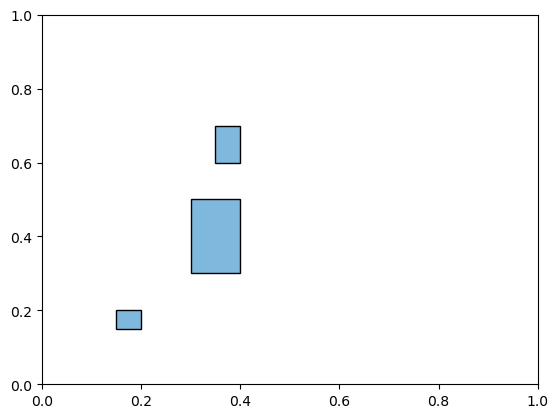

In [4]:
fig, ax = plt.subplots()
ax.set_xlim([0,1])
ax.set_ylim([0,1])
for i in range(xbar_now.shape[0]):
    w = xbar_now[i,1,0] - xbar_now[i,0,0]
    h = xbar_now[i,1,1] - xbar_now[i,0,1]
    ax.add_patch(Rectangle(xbar_now[i,0,:],w, h, edgecolor = 'k',fc=(0, 0.4470, 0.7410,0.5)))
for segment in frontier.values():
    ax.plot([segment[0,0],segment[1,0]],[segment[0,1],segment[1,1]],'k')
for box in box_vertices.keys():
    rays_for_box = []
    for ray in frontier.keys():
        if np.any(np.all(np.array(box_vertices[box]) == frontier[ray][0],axis=1)):
            rays_for_box.append(ray)
    ray0 = min(rays_for_box)
    ray1 = max(rays_for_box)
    seg0 = frontier[ray0]
    seg1 = frontier[ray1]
    if seg0[1,0] == seg1[1,0] or seg0[1,1] == seg1[1,1]:
        # right wall or top wall
        x = [seg0[0,0],seg0[1,0],seg1[1,0],seg1[0,0]]
        y = [seg0[0,1],seg0[1,1],seg1[1,1],seg1[0,1]]
        if seg0[0,1] >= seg1[0,1]:
            # robot on right
            x.append(box_vertices[box][1][0])
            y.append(box_vertices[box][1][1])
        else:
            # robot on left
            x.append(box_vertices[box][0][0])
            y.append(box_vertices[box][0][1])
    else:
        # corner
        if seg0[0,1] >= seg1[0,1]:
            # robot on right
            ray0world = line_intersection(seg0,world_edges[2])
            ray1world = line_intersection(seg1,world_edges[3])
            x = [seg0[0,0],ray0world[0],world_box[0][0],ray1world[0],seg1[0,0],box_vertices[box][1][0]]
            y = [seg0[0,1],ray0world[1],world_box[1][1],ray1world[1],seg1[0,1],box_vertices[box][1][1]]
        else:
            # robot on left
            ray0world = line_intersection(seg0,world_edges[1])
            ray1world = line_intersection(seg1,world_edges[2])
            x = [seg0[0,0],ray0world[0],world_box[1][0],ray1world[0],seg1[0,0],box_vertices[box][0][0]]
            y = [seg0[0,1],ray0world[1],world_box[1][1],ray1world[1],seg1[0,1],box_vertices[box][0][1]]

    # x = np.array([box_vertices[box][0][0],box_vertices[box][1][0],max(frontier[ray0][1,0],frontier[ray1][1,0])])
    # y1_0 = np.tan(ray0)*x[1:3]+(frontier[ray0][0,1]-np.tan(ray0)*frontier[ray0][0,0])
    # y1 = np.insert(y1_0,0,box_vertices[box][0][1])
    # y2 = np.tan(ray1)*x+(frontier[ray1][0,1]-np.tan(ray1)*frontier[ray1][0,0])
    # print(x,y1,y2)
    ax.fill(x,y,edgecolor = 'None',alpha=0.2)
# ax.scatter(*zip(*candidates))
plt.show()

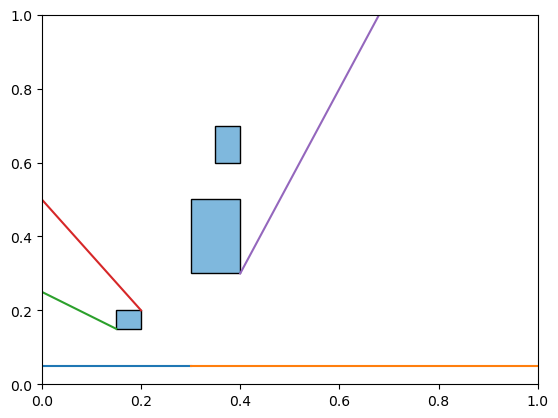

In [28]:
plot_frontier(xbar_now, world_box, start, FoV)

In [5]:
# 10/24/23 TODO: WORKING HERE
# planner function
def occlusion(xbar_now, world_box, start, FoV):
    '''Find box:vertex, vertex:ray, ray:segment'''
    frontier, box_vertices, world_edges = find_frontier(xbar_now, world_box, start, FoV, polygon=True)

    '''Find polygons'''
    polygons = []
    for box in box_vertices.keys():
        rays_for_box = []
        for ray in frontier.keys():
            if np.any(np.all(np.array(box_vertices[box]) == frontier[ray][0],axis=1)):
                rays_for_box.append(ray)
        ray0 = min(rays_for_box)
        ray1 = max(rays_for_box)
        seg0 = frontier[ray0]
        seg1 = frontier[ray1]
        if seg0[1,0] == seg1[1,0] or seg0[1,1] == seg1[1,1]:
            # right wall or top wall
            x = [seg0[0,0],seg0[1,0],seg1[1,0],seg1[0,0]]
            y = [seg0[0,1],seg0[1,1],seg1[1,1],seg1[0,1]]
            if seg0[0,1] >= seg1[0,1]:
                # robot on right
                x.append(box_vertices[box][1][0])
                y.append(box_vertices[box][1][1])
            else:
                # robot on left
                x.append(box_vertices[box][0][0])
                y.append(box_vertices[box][0][1])
        else:
            # corner
            if seg0[0,1] >= seg1[0,1]:
                # robot on right
                ray0world = line_intersection(seg0,world_edges[2])
                ray1world = line_intersection(seg1,world_edges[3])
                x = [seg0[0,0],ray0world[0],world_box[0][0],ray1world[0],seg1[0,0],box_vertices[box][1][0]]
                y = [seg0[0,1],ray0world[1],world_box[1][1],ray1world[1],seg1[0,1],box_vertices[box][1][1]]
            else:
                # robot on left
                ray0world = line_intersection(seg0,world_edges[1])
                ray1world = line_intersection(seg1,world_edges[2])
                x = [seg0[0,0],ray0world[0],world_box[1][0],ray1world[0],seg1[0,0],box_vertices[box][0][0]]
                y = [seg0[0,1],ray0world[1],world_box[1][1],ray1world[1],seg1[0,1],box_vertices[box][0][1]]
        polygons.append(np.array([x,y]))

    return polygons

In [6]:
# world function
def plot_occlusion(polygons):
    fig, ax = plt.subplots()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    for polygon in polygons:
        ax.fill(polygon[0],polygon[1],edgecolor = 'None',alpha=0.5)
    plt.show()

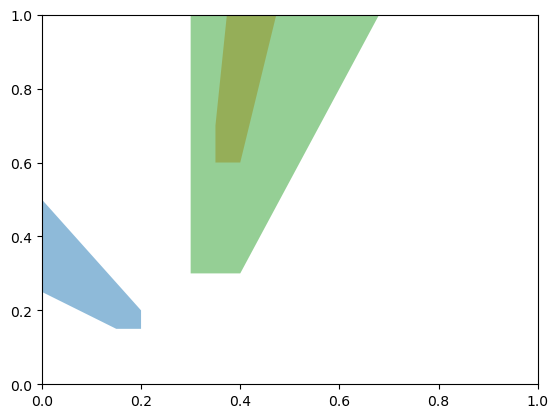

In [7]:
plot_occlusion(occlusion(xbar_now, world_box, start, FoV))

In [6]:
occlusion(xbar_now, world_box, start, FoV)

[array([[ 0.2       , -0.        , -0.        ,  0.15      ,  0.2       ],
        [ 0.2       ,  0.28571429,  0.1875    ,  0.15      ,  0.15      ]]),
 array([[0.4       , 0.33076923, 0.20454545, 0.35      , 0.4       ],
        [0.7       , 1.        , 1.        , 0.6       , 0.6       ]]),
 array([[0.4       , 0.23333333, 0.        , 0.        , 0.3       ,
         0.4       ],
        [0.5       , 1.        , 1.        , 0.6       , 0.3       ,
         0.3       ]])]

In [11]:
frontier

{3.141592653589793: array([[ 0.05,  0.05],
        [-0.  ,  0.05]]),
 0.0: array([[0.05, 0.05],
        [1.  , 0.05]]),
 0.5880026035475675: array([[0.2       , 0.15      ],
        [1.        , 0.68333333]]),
 0.982793723247329: array([[0.15 , 0.2  ],
        [0.3  , 0.425]]),
 1.0040671092713902: array([[0.4       , 0.6       ],
        [0.65454545, 1.        ]]),
 1.1383885512243588: array([[0.35      , 0.7       ],
        [0.48846154, 1.        ]]),
 0.6202494859828214: array([[0.4       , 0.3       ],
        [1.        , 0.72857143]]),
 1.0636978224025597: array([[0.3       , 0.5       ],
        [0.35555556, 0.6       ]])}

In [13]:
line_intersection(np.array([[0.3       , 0.5       ],
        [0.35555556, 0.6       ]]),world_edges[2])

[0.5777778000000001, 1.0]

In [89]:
for box in box_vertices.keys():
    rays_for_box = []
    for ray in frontier.keys():
        if np.any(np.all(np.array(box_vertices[box]) == frontier[ray][0],axis=1)):
            rays_for_box.append(ray)
            # this ray comes from this box
            print('ray: ', ray, 'box: ', box)

ray:  0.5880026035475675 box:  0
ray:  0.982793723247329 box:  0
ray:  1.0040671092713902 box:  1
ray:  1.1383885512243588 box:  1
ray:  0.6202494859828214 box:  2
ray:  1.0636978224025597 box:  2


In [114]:
def find_polygon(ray0, ray1):
    x = np.array([box_vertices[box][0][0],box_vertices[box][1][0],max(frontier[ray0][1,0],frontier[ray1][1,0])])


array([0.15])

In [110]:
np.insert([0.15,0.15])

0.2

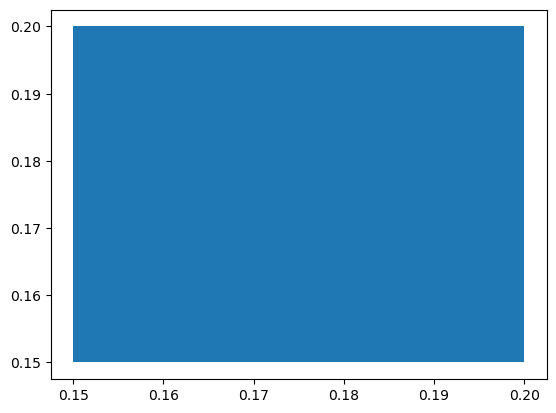

In [131]:
x = np.array([0.15,0.2,0.2,0.15])
y = np.array([0.15,0.15,0.2,0.2])


fig, ax = plt.subplots()
ax.fill(x, y)
plt.show()

In [141]:
x

[0.2, -0.0, -0.0, 0.15, [0.2]]

In [127]:
box1 = np.array([[0.1,0.2],[0.8,0.6]])
box2 = np.array([[0.3,0.5],[0.4,0.7]])
box3 = np.array([[0.3,0.5],[0.4,0.6]])
box4 = np.array([[0.3,0.75],[0.4,0.8]])

In [128]:
xa = np.array([box1, box2, box3])
xb = np.array([box1, box2])
xc = np.array([box2, box3])
xd = np.array([box4])

In [102]:
def non_det_filter(xbar_prev, xhat_now):
    '''
    implements non-deterministic filter
    inputs: xbar_prev, xhat_now
    xbar_prev: previous estimate of occ_space
    xhat_now: current estimate of occ_space
    
    output: xbar_now, updated estimate of occ_space
    '''
    if len(xbar_prev) == 0:
        return xhat_now
    else:
        ab_all = []
        for a in xbar_prev:
            for b in xhat_now:
                ab = overlap(a, b)
                #print(ab_all)
                if np.all(a==ab) and np.all(b==ab):
                    # a,b same box, keep one
                    ab_all.append(ab)
                if (ab is None):
                    # no overlap
                    continue
                else:
                    ab_all.append(ab)
        if len(ab_all) == 0:
            return []
        else:
            ab_all_unique = []
            for ab in ab_all:
                if not any(np.all(ab == x) for x in ab_all_unique):
                    ab_all_unique.append(ab)
            xbar_now = np.concatenate(ab_all_unique)
            return xbar_now

In [82]:
def show(oc):
    fig, ax = plt.subplots()
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    for i in range(len(oc)):
        w = oc[i,1,0] - oc[i,0,0]
        h = oc[i,1,1] - oc[i,0,1]
        ax.add_patch(Rectangle(oc[i,0,:],w, h, edgecolor = 'k',fc=(0, 0.4470, 0.7410,0.5)))

    return fig,ax

0


(<Figure size 640x480 with 1 Axes>, <Axes: >)

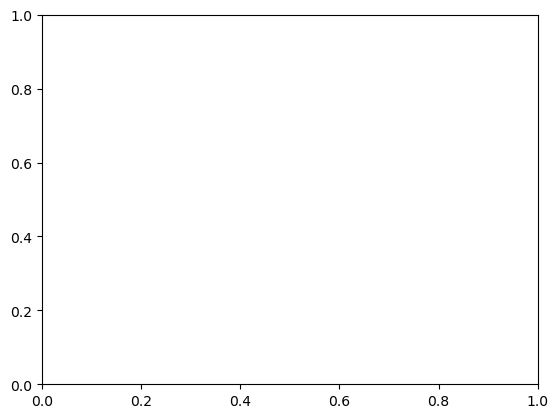

In [129]:
oc = non_det_filter(xa,xd)
print(len(oc))
show(oc)